In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# import glob 

# from dask.distributed import Client, LocalCluster

In [2]:
# Non-RR paths
flux_path1 = "/resstore/b0243/Data/mmkupilas/processed_data/vertical_flx_wtrans/flux/monthly/"
flux_filename1 = "on_lev_nonrr_flx_monthly_mean_2010-06.nc"
means_path1 = "/resstore/b0243/Data/mmkupilas/processed_data/vertical_flx_wtrans/time_domain_means/monthly/"
means_filename1 = "on_lev_nonrr_monthly_mean_2010-06.nc"

In [3]:
ds1_flux = xr.open_dataset(flux_path1+flux_filename1)
ds1_means = xr.open_dataset(means_path1+means_filename1)

In [4]:
# RR
flux_path2 = flux_path1
flux_filename2 = "on_lev_rr_flx_monthly_mean_2010-06.nc"
means_path2 = means_path1
means_filename2 = "on_lev_rr_monthly_mean_2010-06.nc"


In [5]:
ds2_flux = xr.open_dataset(flux_path2+flux_filename2)
ds2_means = xr.open_dataset(means_path2+means_filename2)

In [8]:
# Constants and factors
R = 287 # gas constant for dry air J kg-1 K-1 
g = 9.81 # acceleration due to gravity m s-1

H1 = (R*ds1_means['T']/g)[::-1][1:].values # model 1 scale height (m) | [::-1] reverses list so that height increases with index
H2 = (R*ds2_means['T']/g)[::-1][1:].values # model 2 scale height (m)


In [53]:
# vertical coordinates for plotting
# 1. Calculate difference in log pressure between two mid points, store in array.
# 2. Half each difference from 1.
# 3. Subtract 2 from log pressure in mid points. Gives us pressure at interfaces.  
iloglev = np.log10(ds1_means['lev'].values[::-1][1:]) - np.diff(np.log10(ds1_means['lev'][::-1]))/2

# dlogP for computing derivatives
d_logP = np.diff(np.log10(ds1_flux['lev'])[::-1].values) 



# Constituents


In [50]:
def rhotend(d_rho_flux, H, d_logP):
    dT_dt = (1/H)*(d_rho_flux/d_logP)
    return dT_dt # return as particles cm-3 s-1

In [ ]:
# Plot fluxes
for var in ['O','NO','CO','CO2']:
    d_rho_flux1 = np.diff(ds1_flux[var+'_n_flux'][::-1].values)
    d_rho_flux2 = np.diff(ds2_flux[var+'_n_flux'][::-1].values)
    
    factor = 1
    if var == 'CO':
        factor = 1e-6
    
    drho_dt1 = rhotend(d_rho_flux1,H1,d_logP)*factor
    drho_dt2 = rhotend(d_rho_flux2,H2,d_logP)*factor
    
    plt.figure(figsize=(4,5))
    user_labelsize = 12
    
    plt.plot(drho_dt1,10**iloglev,label='Non-RR')
    plt.plot(drho_dt2,10**iloglev,label='RR')
    plt.axvline(0,color='k',linewidth=0.5,linestyle=(0,(5,5)),alpha=0.5)

    plt.yscale('log')
    plt.ylim(1.5e-1,6e-5)
    plt.tick_params(direction='in',which='both',labelsize=user_labelsize)

    plt.ylabel('Pressure (hPa)',fontsize=user_labelsize)
    plt.xlabel(var + r' Tendency (cm$^{-3}$ s$^{-1}$)',fontsize=user_labelsize)
    if var == 'CO':
        plt.xlabel(var + r' Tendency (x10$^6$ cm$^-3$ s$^{-1}$)',fontsize=user_labelsize)

    plt.legend()
    
    

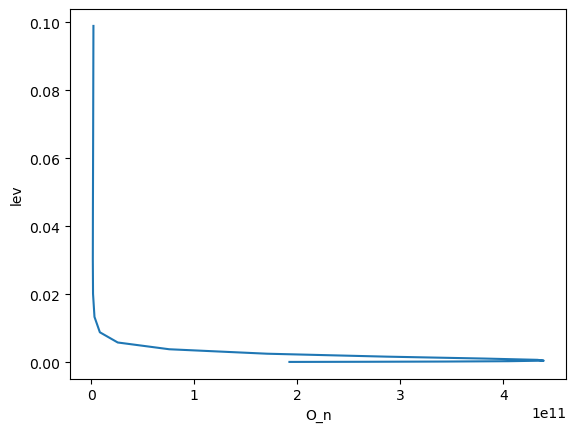

In [9]:
ds1_means['O_n'].plot(y='lev')

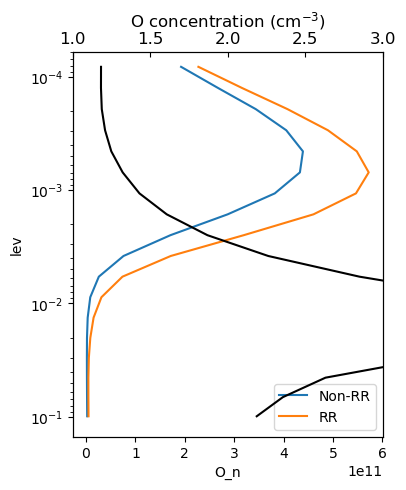

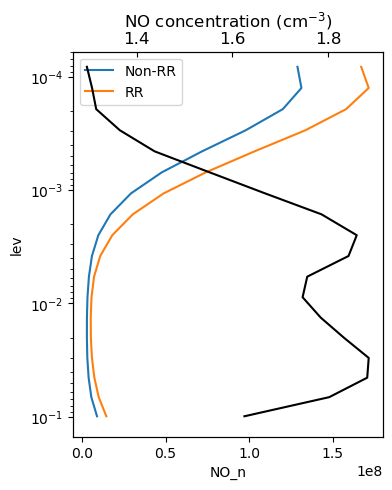

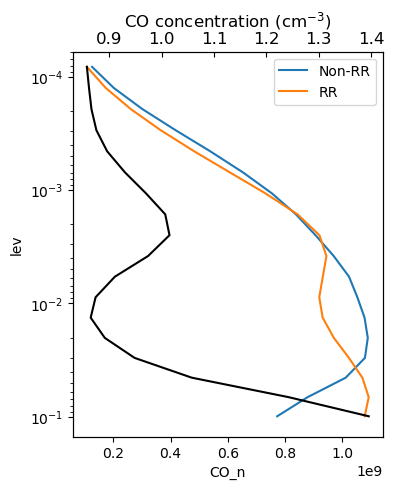

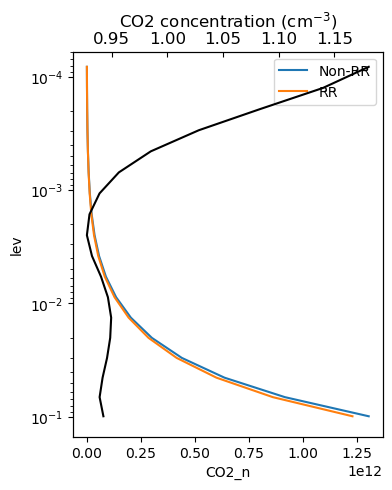

In [22]:
# Plot density profiles
for var in ['O','NO','CO','CO2']:
    ds_rho1 = ds1_means[var + '_n']
    ds_rho2 = ds2_means[var + '_n']
    
    ds_diff = ds_rho2/ds_rho1
    
    # if var == 'CO2':
    #     ds_rho1 = np.log10(ds_rho1)
    #     ds_rho2 = np.log10(ds_rho2)
    
    factor = 1
    # if var == 'CO':
    #     factor = 1e-6
    
    plt.figure(figsize=(4,5))
    user_labelsize = 12
    
    ax1 = plt.gca()
    
    ds_rho1.plot(ax=ax1, y='lev',label='Non-RR')
    ds_rho2.plot(ax=ax1, y='lev',label='RR')
    
    ax1.legend()
    
    ax2 = ax1.twiny()
    ds_diff.sel(lev=slice(5e-5,5e-1)).plot(ax=ax2, y='lev',label='RR/Non-RR',color='k')

    if var == 'O':
        ax2.set_xlim(1,3)


    plt.yscale('log')
    plt.ylim(1.5e-1,6e-5)
    plt.tick_params(direction='in',which='both',labelsize=user_labelsize)

    plt.ylabel('Pressure (hPa)',fontsize=user_labelsize)
    plt.xlabel(var + r' concentration (cm$^{-3}$)',fontsize=user_labelsize)
    # if var == 'CO':
    #     plt.xlabel(var + r' Tendency (x10$^6$ cm$^-3$ s$^{-1}$)',fontsize=user_labelsize)

    # plt.legend()
    
    


# Momentum


# Temperature

In [15]:
def ttend(d_T_flux, H, d_logP, T_flux, d_logT_mean):
    dT_dt = (1/H)*(d_T_flux/d_logP) + T_flux*(1/H - (1/H)*(d_logT_mean/d_logP))
    return dT_dt*24*60*60 # return as K/day

In [16]:
# Non-RR temperature tendency
T_flux1 = ds1_flux['T_flux'][::-1][1:]
d_T_flux_1 = np.diff(ds1_flux['T_flux'][::-1].values) # reversed list such that height increases with index
d_logT_mean_1 = np.diff(np.log10(ds1_means['T'][::-1].values)) # dlog(T)

dT_dt1 = ttend(d_T_flux_1, H1, d_logP,T_flux1, d_logT_mean_1)

In [17]:
# R temperature tendency
T_flux2 = ds2_flux['T_flux'][::-1][1:]
d_T_flux_2 = np.diff(ds2_flux['T_flux'][::-1].values) # reversed list such that height increases with index
d_logT_mean_2 = np.diff(np.log10(ds2_means['T'][::-1].values)) # dlog(T)

dT_dt2 = ttend(d_T_flux_2, H2, d_logP,T_flux2, d_logT_mean_2)

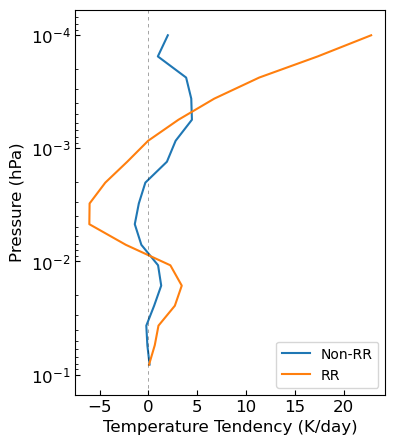

In [36]:
plt.figure(figsize=(4,5))
user_labelsize = 12
plt.plot(dT_dt1,10**iloglev,label='Non-RR')
plt.plot(dT_dt2,10**iloglev,label='RR')
plt.axvline(0,color='k',linewidth=0.5,linestyle=(0,(5,5)),alpha=0.5)

plt.yscale('log')
plt.ylim(1.5e-1,6e-5)
plt.xticks([-5,0,5,10,15,20])
plt.tick_params(direction='in',which='both',labelsize=user_labelsize)

plt.ylabel('Pressure (hPa)',fontsize=user_labelsize)
plt.xlabel('Temperature Tendency (K/day)',fontsize=user_labelsize)

plt.legend()

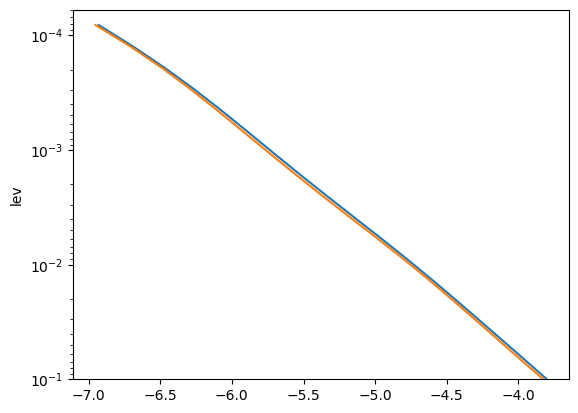

In [43]:
(np.log10(ds1_means['lev']*100/(R*ds1_means['T']))).plot(y='lev',yscale='log',ylim=[1e-1,6e-5])
(np.log10(ds2_means['lev']*100/(R*ds2_means['T']))).plot(y='lev',yscale='log',ylim=[1e-1,6e-5])

In [48]:
delta = (ds2_means['lev']*100/(R*ds2_means['T']))/(ds1_means['lev']*100/(R*ds1_means['T']))

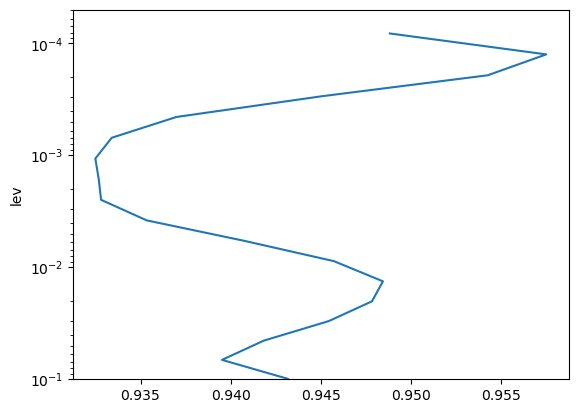

In [49]:
delta.plot(y='lev',yscale='log',ylim=[1e-1,5e-5])